# Clustering - Tuto 1

In this tuto we play with a realistic 1D dataset from Argo data and clustering with GMM.

The goal is to understand better how GMM works, and its limitations.


In [1]:
# Libraries import section
import os

import xarray as xr
import numpy as np
from scipy import stats
from scipy import signal

from sklearn import preprocessing
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

import matplotlib
# matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep", color_codes=True)

OSError: Could not find lib c or load any of its variants [].

In [ ]:
# Define usefull functions

def create_map(extent=[-180, 180, -70, 70]):
    fig = plt.figure(figsize=(12,4),dpi=200)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([0,0,1,1],projection=proj)
    ax.set_extent(extent, crs=proj)
    gl=ax.gridlines(crs=proj, draw_labels=True,
        linewidth=0.5, color=[0.6]*3, alpha=0.5, linestyle='--')
    # gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    # gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/30+1))
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/20+1))
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor=[0.7]*3)
    ax.add_feature(cfeature.COASTLINE)
    return fig, proj, ax

def gaussian(x, mu, sigsq):
    scale = 1/np.sqrt(2*np.pi*sigsq)
    return scale*np.exp(-np.power(x - mu, 2.) / (2 * sigsq))

# Load data

In [3]:
# https://storage.cloud.google.com/sonific01/ARGO/GLOB_HOMOGENEOUS_variables_3subset_3.nc?_ga=2.221604568.-1386953781.1538471925

# Define where to find the Argo file on disk:
ncroot = '/home1/datahome/gmaze/datawork/data/ARGO/copoda_db/global'
ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_1.nc'
#ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_*.nc'

# Load Argo SDL data:
ds = xr.open_dataset(os.path.join(ncroot,ncfile),chunks={'N_PROF':16000})
ds = ds.set_coords(['LATITUDE','LONGITUDE','TIME'])
# ds = ds.where(ds['LATITUDE']>=0, drop=True)
# ds = ds.where(ds['LONGITUDE']>=-80, drop=True)
# ds = ds.where(ds['LONGITUDE']<=0, drop=True)
# ds = ds.chunk({'N_PROF': 100})
print ds

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 67010)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE   (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(67010,), chunksize=(16000,)>
Dimensions without coordinates: N_PROF
Data variables:
    DBINDEX    (N_PROF) float64 dask.array<shape=(67010,), chunksize=(16000,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
Attributes:
    Title:             VENTHSAL-IA
    long_title:        Argo subset of plain pr

# Stats for 1D data

In [4]:
# z = -250
# X, Xlabel = ds.TEMP.sel(DEPTH=z,method='nearest'), "TEMP@%0.2fm"%(z)

X, Xlabel = ds.TEMP.mean(dim='DEPTH'), "VERTICAL MEAN TEMP"
# X = X[np.where(X>3)]
print X
print Xlabel
print X.shape

<xarray.DataArray 'TEMP' (N_PROF: 67010)>
dask.array<shape=(67010,), dtype=float32, chunksize=(16000,)>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(67010,), chunksize=(16000,)>
Dimensions without coordinates: N_PROF
VERTICAL MEAN TEMP
(67010,)


Text(0.5,1,'VERTICAL MEAN TEMP')

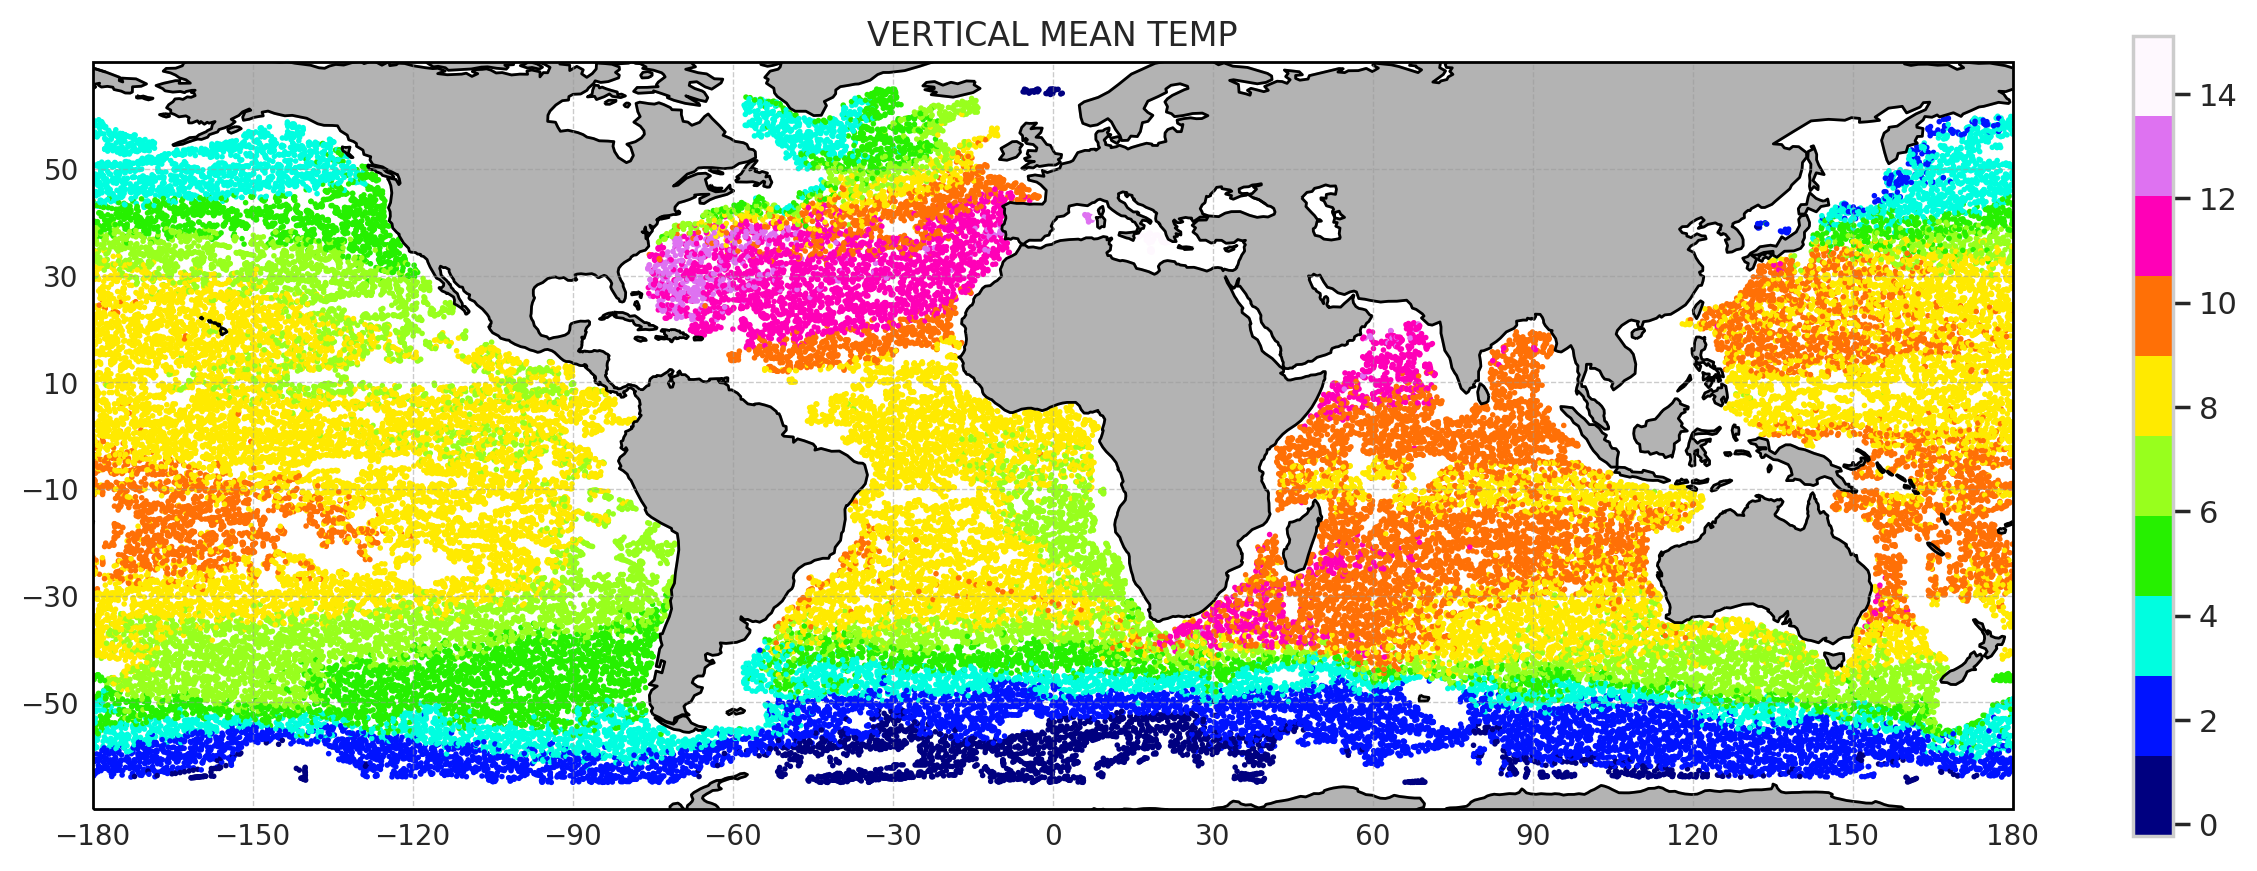

In [5]:
fig, proj, ax = create_map()
plt.scatter(X.LONGITUDE, X.LATITUDE, 1, X, cmap=plt.cm.get_cmap('gist_ncar',10))
plt.colorbar()
plt.title(Xlabel)

/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


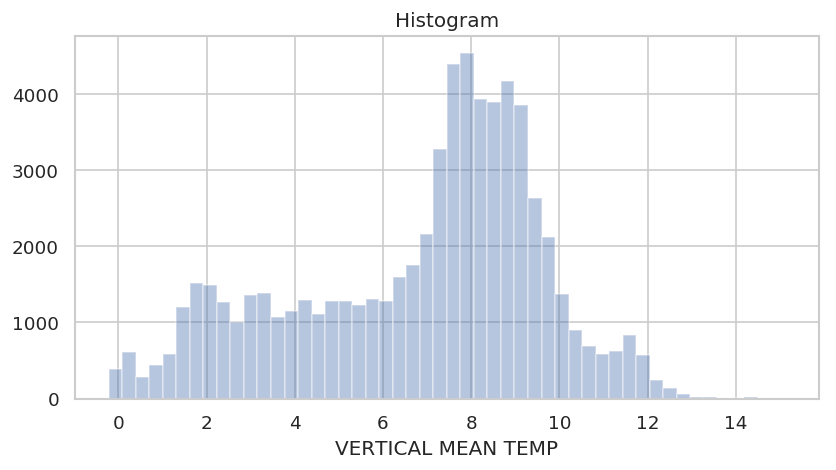

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('Histogram')
sns.distplot(X, kde=False, axlabel=Xlabel)
# sns.distplot(X, bins=np.linspace(-2.,20.,22+1), kde=False, axlabel=Xlabel)
# n, bins, patches = plt.hist(x, bins=np.linspace(-2.,20.,22+1))

# Pre-process data

Normalisation step

In [7]:
# From xarray, X has shape: (67010,)
# For scikitlearn we need X with shape: [67010,1]
X0 = X.values[np.newaxis].T
print "Data shape [n_samples, n_features]:", X0.shape # shape [n_samples, n_features=1]

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X0)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_
print "Data mean, std:", X_ave, X_std

# Normalize data:
Xn = scaler.transform(X0)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X0).transform(X0)

Data shape [n_samples, n_features]: (67010, 1)
Data mean, std: [6.82879794] [2.82974905]


In [8]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
# axes.set_title('Histogram of normalised data')
# sns.distplot(Xn, kde=False, axlabel=Xlabel)

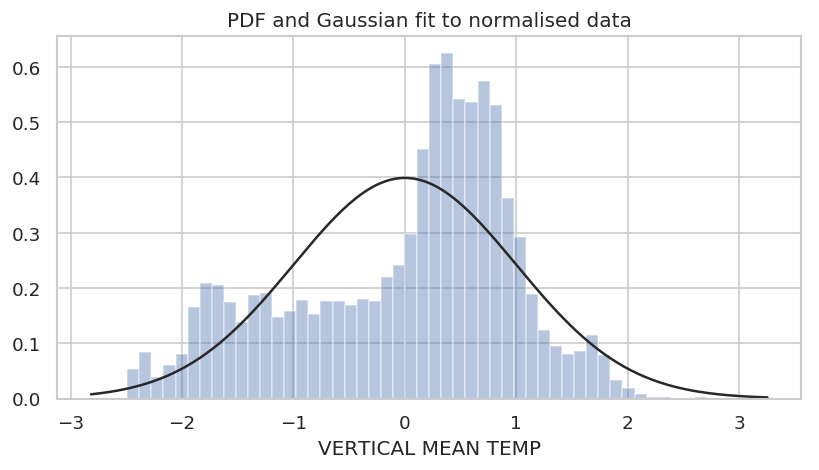

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('PDF and Gaussian fit to normalised data')
sns.distplot(Xn, kde=False, fit=stats.norm, axlabel=Xlabel)

# Clustering in 1D

Clearly from the figure above, one can see that the dataset is not Gaussian and exhibits several modes. In other words, data samples agregated into several clusters.

Let's identify them

## Use a GMM to identify modes (the "clusters") in the distribution

In [10]:
from sklearn.mixture import GaussianMixture as GMM

# Clustering with GMM
gmm = GMM(n_components=4)
gmm = gmm.fit(Xn)
labels = gmm.predict(Xn)
n_clusters = np.unique(labels).shape[0]
for k in range(n_clusters):
    print "Cluster %i mean(std), weight: %0.2f (%0.2f), %0.2f"%(k, gmm.means_[k,0], gmm.covariances_[k,0],gmm.weights_[k])
# print np.sum(gmm.weights_) # Should be 1.

# Compute the GMM dataset pdf:
x = np.linspace(-3,3,200)
gmm_pdf = np.zeros(x.shape)
for k in range(n_clusters):
    gmm_pdf += gmm.weights_[k]*gaussian(x, gmm.means_[k,0], gmm.covariances_[k,0])

Cluster 0 mean(std), weight: 0.44 (0.10), 0.43
Cluster 1 mean(std), weight: -1.63 (0.16), 0.19
Cluster 2 mean(std), weight: 1.02 (0.24), 0.21
Cluster 3 mean(std), weight: -0.59 (0.15), 0.17


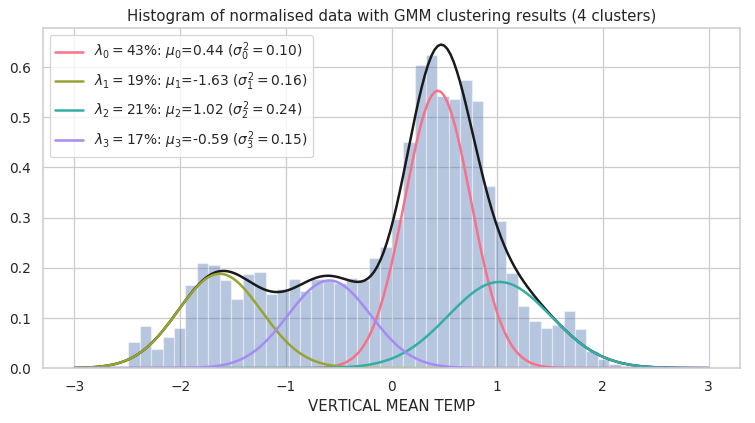

In [11]:
colors = sns.husl_palette(n_clusters)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
ax = sns.distplot(Xn, norm_hist=True, kde=False, ax=ax, axlabel=Xlabel)
# ax = sns.distplot(Xn, kde=True, ax=ax, axlabel=Xlabel)
# ax = sns.distplot(Xn, hist=False, ax=ax, axlabel=Xlabel)
ax.set_title('Histogram of normalised data with GMM clustering results (%i clusters)'%n_clusters)
plt.plot(x,gmm_pdf,'k', linewidth=2)
for k, col in zip(range(n_clusters),colors):
#     ax.vlines(gmm.means_[k,0],0,1)
#     plt.plot(x,gaussian(x, gmm.means_[k,0], gmm.covariances_[k,0]),color=col,linestyle='--')
    plt.plot(x,gmm.weights_[k]*gaussian(x, gmm.means_[k,0], gmm.covariances_[k,0]),\
             color=col, linewidth=2, label="$\lambda_%i=%0.0f$%%: $\mu_%i$=%0.2f ($\sigma^2_%i=%0.2f$)"%(k, gmm.weights_[k]*100, k, gmm.means_[k,0], k, gmm.covariances_[k,0]))
plt.legend()

## How to select the nb of cluster ?

This is the most problematic question in clustering.

It is a rather difficult problem to determine automatically the most appropriate number of components. There exist different methods that are mostly based on estimating the most probable K, or minimizing a given metric such as the mixture entropy or misfit with the observed PDF (Fraley et al., 1998). A popular method is the Bayesian Information Criterion (BIC, Schwarz, 1978). The BIC is an empirical approach of the model probability computed as:

$$BIC(K) = -2\,\mathcal{L}(K) + N_f(K)\,\log(n) \label{eq:bic}$$

where $\mathcal{L}(K)$ is the log likelihood of the trained model with $K$ classes, $N_f(K)=K-1+K\,D+K\,D\,(D+1)/2$ is the number of independent parameters to be estimated (the sum of the component weights, Gaussian means and covariance matrix elements in the D-dimensional data space) and $n$ is the number of profiles used to train the model.

The BIC is empirical because the first r.h.s. term decreases as the number of classes K increases while the second r.h.s. term is a penalty term that increases with K and thus prevents model overfitting the data. The sum of the two terms is expected to exhibit a minimum for the most appropriate $K$.

In [13]:
kmax = 20
BIC = np.zeros((kmax))
BICf = np.zeros((kmax))

print Xn.shape[0]
n = Xn.shape[0] # Nb of samples
n = 900
n = 2196

for k in range(kmax):
    this_gmm = GMM(n_components=k+1).fit(Xn)
    BIC[k] = this_gmm.bic(Xn)
    D = 1 # Nb of dimension
    Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2 # Nb of independant parameters to estimate
#     print Nf, this_gmm._n_parameters()
    BICf[k] = -2*n*this_gmm.score(Xn) + Nf*np.log(n)

67010


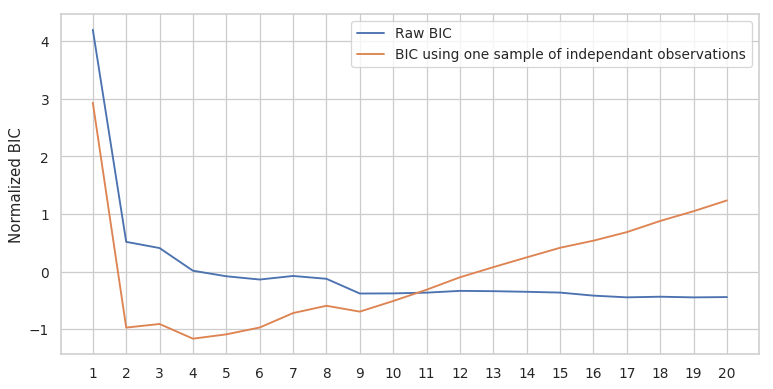

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(kmax)+1,(BICf-np.mean(BICf))/np.std(BICf), label='BIC using one sample of independant observations')
plt.ylabel('Normalized BIC')
plt.xticks(np.arange(kmax)+1)
plt.legend()

In [15]:
kmax = 20
Nrun = 30
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

print Xn.shape[0]
n = Xn.shape[0] # Nb of samples
n = 2196

for run in range(Nrun):
    for k in range(kmax):
        ii = np.random.choice(range(X.shape[0]), n, replace=False)
        this_gmm = GMM(n_components=k+1).fit(Xn[ii])
        BIC[k,run] = this_gmm.bic(Xn[ii])
        D = 1 # Nb of dimension
        Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2 # Nb of independant parameters to estimate
    #     print Nf, this_gmm._n_parameters()
        BICf[k,run] = -2*n*this_gmm.score(Xn[ii]) + Nf*np.log(n)

67010


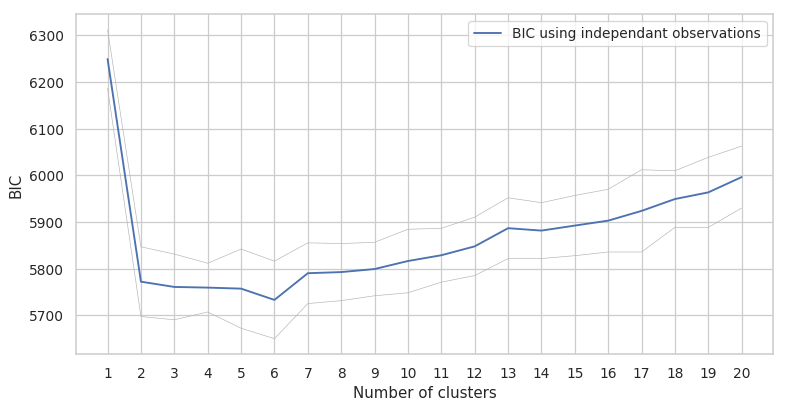

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICfmean = np.mean(BICf,axis=1)
BICfstd = np.std(BICf,axis=1)
normBICfmean = (BICfmean-np.mean(BICfmean))/np.std(BICfmean)
plt.plot(np.arange(kmax)+1,BICfmean, 
         label='BIC using independant observations')
plt.plot(np.arange(kmax)+1,BICfmean+BICfstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(kmax)+1,BICfmean-BICfstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(kmax)+1)
plt.legend()